<div class="alert alert-block alert-success">
    <h1 align="center">Plant Classification</h1>
    <h3 align="center">A2NDL POLIMI</h3>

</div>

### 1-Mount Google drive and unzip data

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip -qq "/content/drive/MyDrive/Projects/1st A2NDL Project/Dataset/public_data.zip" -d "/content"

### 2-Import Libraries

In [3]:
import os, datetime, warnings, logging, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from keras import callbacks
from keras import layers
from keras import models
from keras.layers import Dropout
import keras
from keras import optimizers
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2, glob, random, os, time, shutil, datetime,time, keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D, BatchNormalization, Activation, Input, Add, Dense, ZeroPadding2D,Flatten, AveragePooling2D, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import layers, callbacks , metrics
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix
%load_ext tensorboard

### 3-Fix randomness and hide warnings

In [4]:
seed = 42
#####
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#####
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
#####
np.random.seed(seed)
random.seed(seed)

### 4-Set first parameters of tensorflow

In [5]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


### 5-Load dataset

In [6]:
dataset = np.load("/content/public_data.npz", allow_pickle=True)

### EDA On Dataset

In [7]:
# Watch keys available in the numpy array
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

# look at data
data = dataset["data"]
no_images = data.shape[0]
size_images = data.shape[1:3]
print('Data shape: ',data.shape)
print('*'*100)

# Lool aat labels
labels = dataset["labels"]
no_labels = labels.shape[0]
print("Labels are : ",labels)
print('*'*100)

# Look at bing balanced or imblanced
_, counts = np.unique(labels,return_counts=True)
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]
info_table_dict = {"no_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "no_labels":no_labels,
                   "no_healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "no_unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

keys in our dataset are:  ['data', 'labels']
****************************************************************************************************
Data shape:  (5200, 96, 96, 3)
****************************************************************************************************
Labels are :  ['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']
****************************************************************************************************


,no_images,image_width,image_length,no_labels,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,5200,96,96,5200,3199,61.519231,2001,38.480769


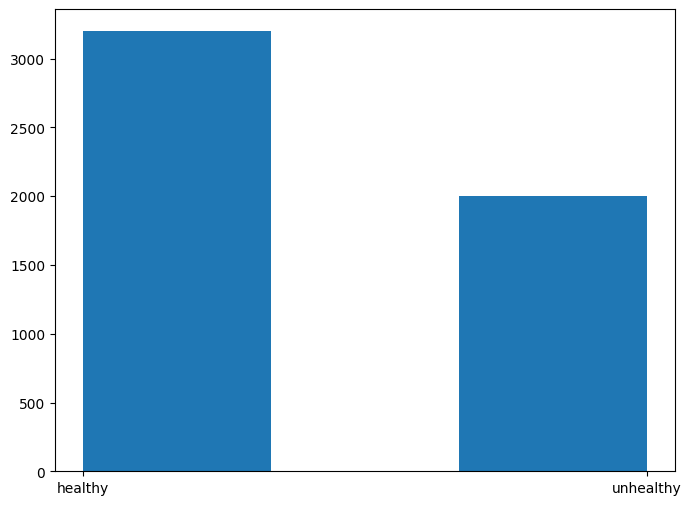

In [8]:
plt.figure(figsize=(8,6))
plt.hist(labels, bins=3,align='mid')
plt.show()

In [9]:
# Turn healty and unhealthy labels to two classes of 0 and 1, using labelEncoder
before = labels.copy()

# Create a LabelEncoder
label_encoder = preprocessing.LabelEncoder()
# Fit and transform the encoder on the original array
labels = label_encoder.fit_transform(labels)

after = labels.copy()
print(f"before label encoding list is like this :{before}. And, unique items are: {np.unique(before)}")
print(f"after label encoding list is like this :{after}. And, unique items are: {np.unique(after)}")

before label encoding list is like this :['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']. And, unique items are: ['healthy' 'unhealthy']
after label encoding list is like this :[0 0 0 ... 0 0 0]. And, unique items are: [0 1]


#### Plot images

In [10]:
import matplotlib.pyplot as plt

# A function for displaying images in batches
def show_images(data, batch_no, no_images_per_batch, num_cols=5):

    start_index = batch_no * no_images_per_batch

    end_index = min((batch_no + 1) * no_images_per_batch, len(data))

    num_rows = (end_index - start_index + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, ax in enumerate(axes.ravel()):
        if start_index + i < end_index:
            image = data[start_index + i]
            image = image / 255.0  # Normalize pixel values to [0, 1]
            ax.imshow(image)
            ax.axis('off')

    for i in range(end_index - start_index, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.show()


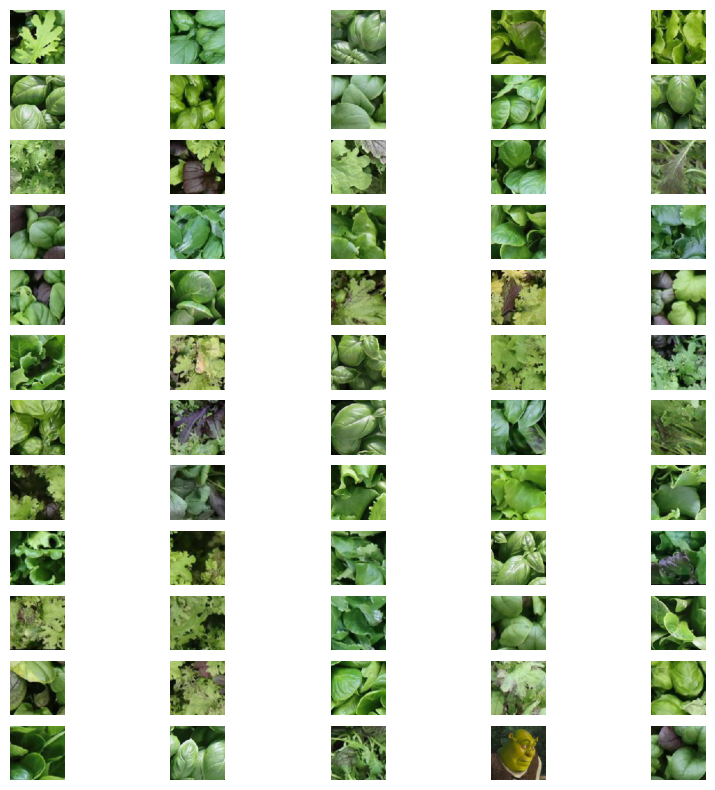

In [11]:
show_images(data=data, batch_no=0,no_images_per_batch=60)

#### Outliers

In [12]:
import cv2

def histogram_similarity(image, reference_histogram, threshold=0.8):

    # Calculate the color histogram of the image
    image_histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(image_histogram, image_histogram)
    intersection = cv2.compareHist(reference_histogram, image_histogram, cv2.HISTCMP_INTERSECT)

    return intersection < threshold


# Load a reference histogram from a non-Shrek-Singer image
reference_image = data[0]  # Use the first image as a reference which I checked before and it's a leaf image
reference_histogram = cv2.calcHist([reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
cv2.normalize(reference_histogram, reference_histogram)


similarity_threshold = 0.62
odd_images = []

# Iterate through the images in data_array
for image in data:
    if histogram_similarity(image, reference_histogram, similarity_threshold):
        odd_images.append(image)


print(f"Detected {len(odd_images)} Odd images.")

Detected 256 Odd images.


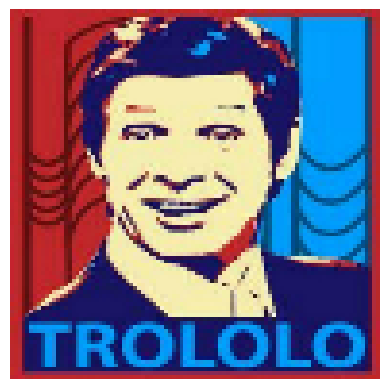

In [13]:
#Creating reference images


reference_unwanted_images = []

# Define the index of the image we want to plot and save as a reference
image_index_trololo = 10  # Replace with the index of the reference image
image_index_shrek = 33

if 0 <= image_index_trololo  and image_index_shrek< len(odd_images):
    # Get the image based on the index
    trololo_reference_image = odd_images[image_index_trololo]
    shrek_reference_image = odd_images[image_index_shrek]

    reference_unwanted_images.append(trololo_reference_image)
    reference_unwanted_images.append(shrek_reference_image)

    # Plot the image
    plt.imshow(reference_unwanted_images[0]/255)
    plt.axis('off')  # Hide axis labels and ticks
    plt.show()

else:
    print("Invalid image index.")

In [14]:
from skimage.color import rgb2lab, deltaE_cie76

#Calculate the color distance between two images using the CIE76 metric.
def calculate_color_distance(image1, image2):

    lab_image1 = rgb2lab(image1)
    lab_image2 = rgb2lab(image2)

    return deltaE_cie76(lab_image1, lab_image2)

def find_unwanted_images_by_color_distance(data_array, reference_unwanted_images, color_distance_threshold):

    cleaned_data = []
    unwanted_images = []
    labels_index =[]
    index =0
    for image in data_array:
        similar = False
        for reference_image in reference_unwanted_images:
            color_distance = calculate_color_distance(image, reference_image)
            if (color_distance < color_distance_threshold).all():
                similar = True
                break  # No need to check further if a match is found
        if (similar == True):
            unwanted_images.append(image)
            labels_index.append(index)
        else:
            cleaned_data.append(image)

        index+=1

    return cleaned_data,unwanted_images, labels_index

color_distance_threshold = 1

cleaned_data,unwanted_images, labels_index = find_unwanted_images_by_color_distance(data, reference_unwanted_images, color_distance_threshold)

In [15]:
unwanted_images = np.stack(unwanted_images, axis=0)

In [16]:
cleaned_data = np.stack(cleaned_data, axis=0)
cleaned_data.shape

(5004, 96, 96, 3)

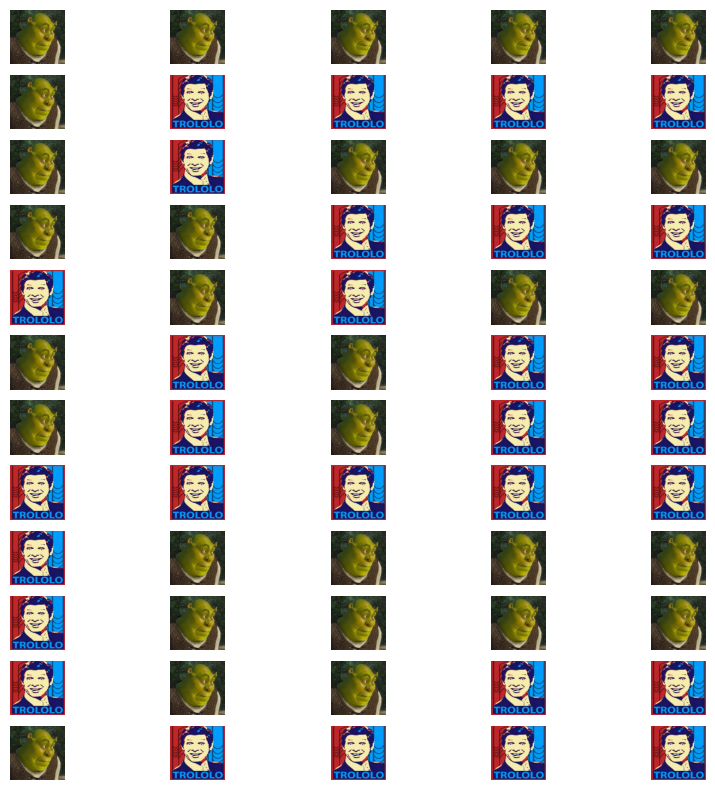

In [17]:
show_images(data=unwanted_images, batch_no=0,no_images_per_batch=60)

In [18]:
labels[labels_index][:60]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [19]:
# Define the indices to remove
indices_to_remove = [10, 20, 14]

# Create a boolean mask for the values to keep
mask = np.ones(labels.shape, dtype=bool)
mask[labels_index] = False
filtered_labels = labels[mask]
filtered_labels.shape

(5004,)

### 5-Splitting data

In [20]:
x_training_data, x_test, y_training_data, y_test = train_test_split(
    cleaned_data,
    filtered_labels,
    test_size = 0.1,
    shuffle =True,
    random_state=seed,
    stratify=filtered_labels)

####5-1 hold_out splitting

In [21]:
# Further split the combined training and validation set into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_training_data,
    y_training_data,
    test_size = len(x_test), # Ensure validation set size matches test set size--> Why??
    random_state=seed,
    shuffle =True,
    stratify=y_training_data)

In [22]:
# Print the shapes of the resulting datasets
print('X_train.shape:',x_train.shape,'y_train.shape:', y_train.shape)
print('X_val.shape:',x_val.shape, 'y_val.shape:',y_val.shape)
print('X_test.shape:',x_test.shape,'y_test.shape', y_test.shape)

X_train.shape: (4002, 96, 96, 3) y_train.shape: (4002,)
X_val.shape: (501, 96, 96, 3) y_val.shape: (501,)
X_test.shape: (501, 96, 96, 3) y_test.shape (501,)


In [23]:
#Understand the same portion of two classes after splititng using stratify
_,count = np.unique(y_train,return_counts=True)
info_table1_dict = {"no_train_images":x_train.shape[0],
                    "no_healthy_images":count[0],"percentage%":count[0]*100/x_train.shape[0],
                   "no_unhealthy_images":count[1],"percentage %":count[1]*100/x_train.shape[0]}
info_table1 = pd.DataFrame(info_table1_dict, index =['value'])
info_table1

,no_train_images,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,4002,2480,61.969015,1522,38.030985


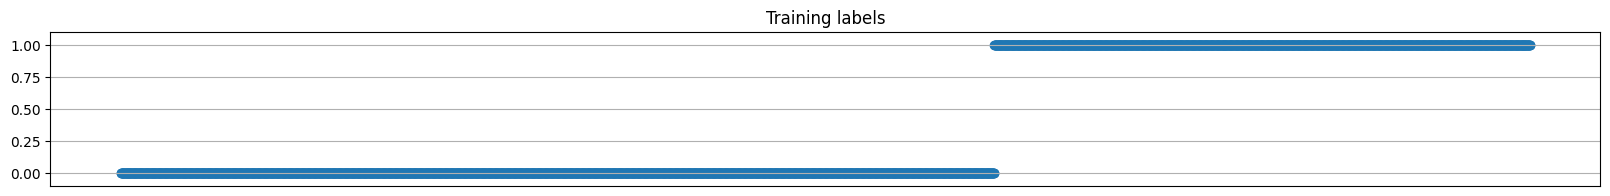

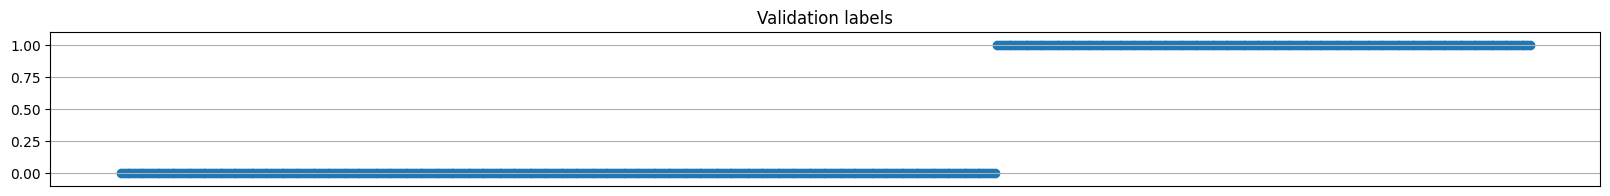

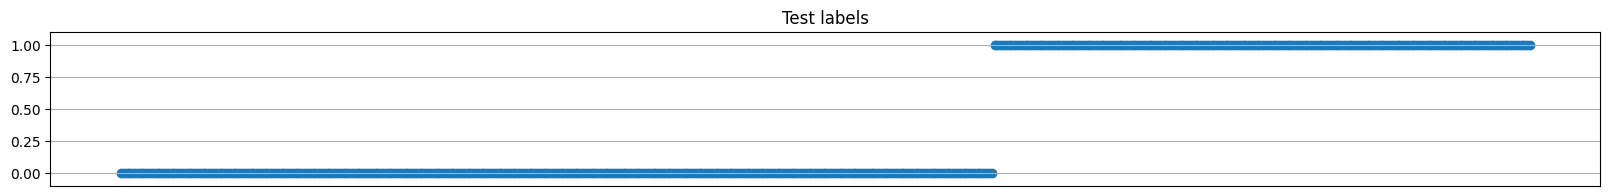

In [24]:
# Create three separate subplots to visualize the sorted target variable values for the training, validation, and test sets

# Create a figure for the training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_train)), np.sort(y_train, axis=0))
plt.title('Training labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the validation labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_val)), np.sort(y_val, axis=0))
plt.title('Validation labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_test)), np.sort(y_test, axis=0))
plt.title('Test labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Display the plots
plt.show()

### 6-Feature scaling

In [25]:
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

### 7-Callbacks

In [26]:
def Checkpoint(address):
  # CheckPoint callback ---> to save wieghts
  checkpoint_path = address # The path to save wights of the model after training
  My_ModelCheckpoint_callback =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode='max',
                                          save_freq ='epoch')
  return My_ModelCheckpoint_callback

In [27]:
# EarlyStopping callback --> Stop learning if it does not see any imporvement.
My_EarlyStopping_callback = callbacks.EarlyStopping(monitor="val_accuracy",
                                                 min_delta=.02,
                                                 patience=30,
                                                 verbose=1,
                                                 mode="max",
                                                restore_best_weights=True)

### 8-Create models

In [28]:
# Define the input shape for the neural network, excluding the batch size
input_shape = x_train.shape[1:]
print('input_shape',input_shape)
# Define the batch size for training
batch_size = 64
# Define the number of training epochs
epochs = 120

input_shape (96, 96, 3)


####8-1 Model_1

In [29]:
def model_1(input_shape=(96, 96, 3)):

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model


In [30]:
def compile(model):
   model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)
   return model

In [31]:
first_model = compile(model_1())

In [32]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [33]:
My_all_callbacks = [My_EarlyStopping_callback, Checkpoint(address="best_models/First_model")]

In [34]:
history = first_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/120
63/63 [==============================] - ETA: 0s - loss: 0.6735 - precision: 0.4143 - recall: 0.0874 - accuracy: 0.6059
Epoch 1: val_accuracy improved from -inf to 0.62076, saving model to best_models/First_model
63/63 [==============================] - 18s 74ms/step - loss: 0.6735 - precision: 0.4143 - recall: 0.0874 - accuracy: 0.6059 - val_loss: 0.6659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.6208
Epoch 2/120
61/63 [============================>.] - ETA: 0s - loss: 0.6482 - precision: 0.6308 - recall: 0.1103 - accuracy: 0.6365
Epoch 2: val_accuracy improved from 0.62076 to 0.63473, saving model to best_models/First_model
63/63 [==============================] - 2s 37ms/step - loss: 0.6456 - precision: 0.6410 - recall: 0.1150 - accuracy: 0.6389 - val_loss: 0.6444 - val_precision: 0.5123 - val_recall: 0.7684 - val_accuracy: 0.6347
Epoch 3/120
61/63 [============================>.] - ETA: 0s - loss: 0.6126 - precision: 0.5943 - recall: 0.4174 -

In [35]:
def plot_accuracy(model_history, name_of_model):
  # Create a figure for loss visualization
  plt.figure(figsize=(21, 4))

  # Plot training and validation loss
  plt.plot(history['accuracy'], label='Training accuracy', alpha=.2, color='#17becf')
  plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#15becf')
  plt.title(f'Accuracy of {name_of_model}')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()


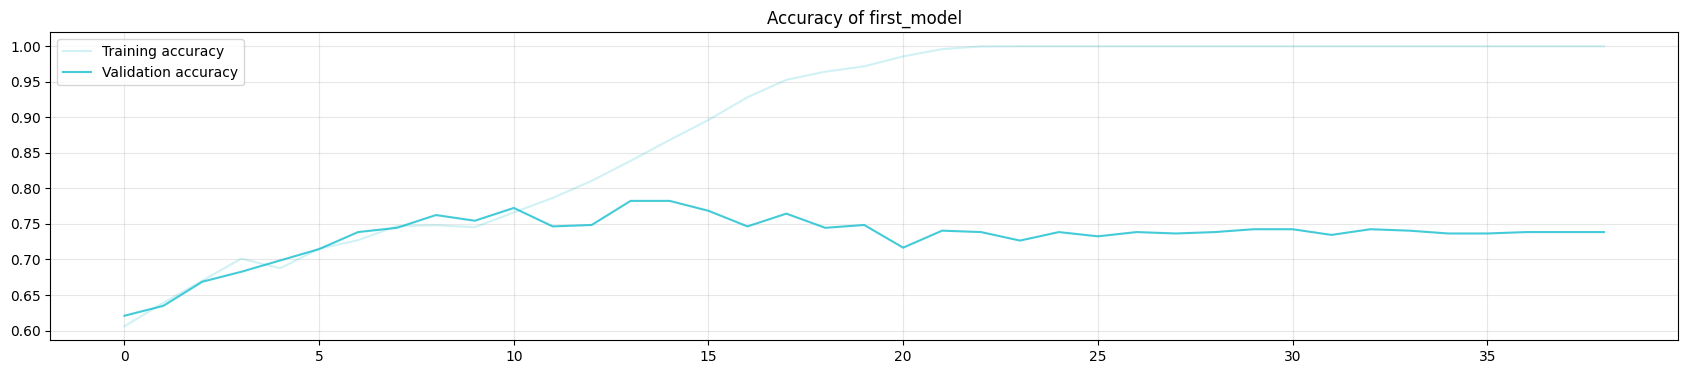

In [36]:
plot_accuracy(model_history= history, name_of_model= "first_model")


In [37]:
val_accuracy ={}

In [38]:
val_accuracy['First']=np.max(history['val_accuracy'])

In [39]:
!mkdir /content/last_models

In [40]:
first_model.save("last_models/First_model.keras")

In [41]:
def model_1_plus_Droput(input_shape=(96, 96, 3)):

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [42]:
second_model = compile(model_1_plus_Droput())

In [43]:
My_all_callbacks = [ My_EarlyStopping_callback, Checkpoint(address="best_models/Second_model")]

In [44]:
history = second_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/120
61/63 [============================>.] - ETA: 0s - loss: 0.6745 - precision_1: 0.4000 - recall_1: 0.0228 - accuracy: 0.6140
Epoch 1: val_accuracy improved from -inf to 0.62076, saving model to best_models/Second_model
63/63 [==============================] - 7s 57ms/step - loss: 0.6741 - precision_1: 0.4000 - recall_1: 0.0223 - accuracy: 0.6154 - val_loss: 0.6740 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.6208
Epoch 2/120
61/63 [============================>.] - ETA: 0s - loss: 0.6572 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.6191
Epoch 2: val_accuracy did not improve from 0.62076
63/63 [==============================] - 2s 29ms/step - loss: 0.6563 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - accuracy: 0.6197 - val_loss: 0.6563 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.6208
Epoch 3/120
61/63 [============================>.] - ETA: 0s - loss: 0.6410 - precision_1: 0.6560 - recall_1: 0

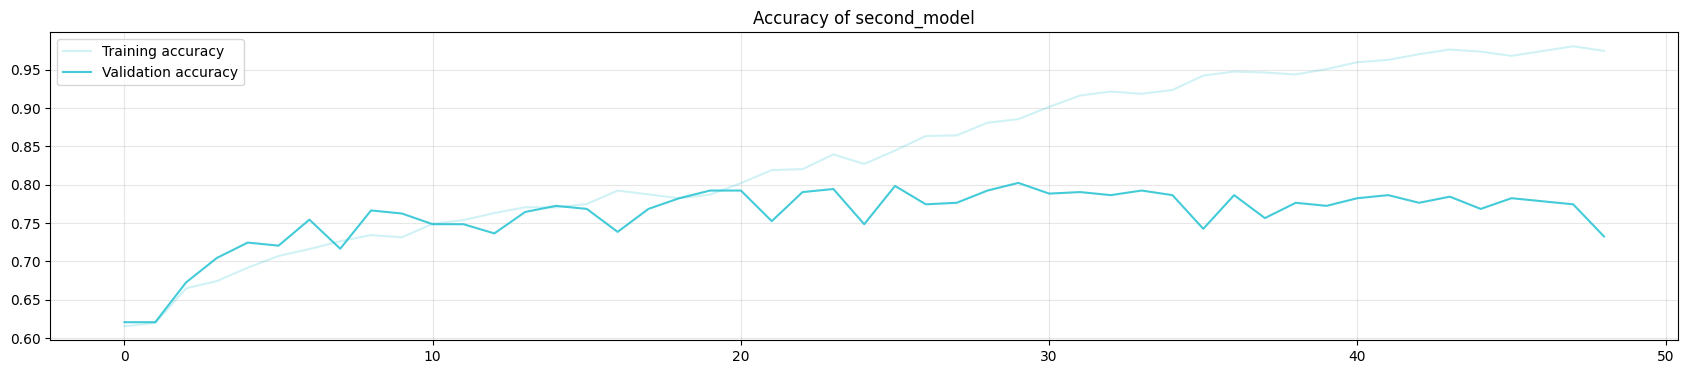

In [45]:
plot_accuracy(model_history= history, name_of_model= "second_model")

In [46]:
val_accuracy['Second']=np.max(history['val_accuracy'])

In [47]:
second_model.save("last_models/Second_model.keras")

#### Data Augumentation

In [49]:
My_all_callbacks = [ My_EarlyStopping_callback, Checkpoint(address="best_models/Third_model")]

In [50]:
def model_1_plus_Droput_aug(input_shape=(96, 96, 3)):

  preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),

    ], name='preprocessing')

  input_layer = tfkl.Input(shape=input_shape, name='Input')
  preprocessing = preprocessing(input_layer)


  x = tfkl.Conv2D(filters=32, kernel_size=3, name='conv0')(preprocessing)
  x = tfkl.ReLU(name='relu0')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp0')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, name='conv1')(x)
  x = tfkl.ReLU(name='relu1')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp1')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp2')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp3')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Flatten()(x)
  dense = tfkl.Dense(units=512, activation='relu',name='dense')(x)
  output_layer = tfkl.Dense(units=1, activation='sigmoid',name='outpu_layer')(dense)

   # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

  return model

In [51]:
third_model = compile(model_1_plus_Droput_aug())

In [52]:
history = third_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/120
61/63 [============================>.] - ETA: 0s - loss: 0.6752 - precision_2: 0.3934 - recall_2: 0.0161 - accuracy: 0.6150
Epoch 1: val_accuracy improved from -inf to 0.62076, saving model to best_models/Third_model
63/63 [==============================] - 7s 68ms/step - loss: 0.6750 - precision_2: 0.3934 - recall_2: 0.0158 - accuracy: 0.6164 - val_loss: 0.6757 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.6208
Epoch 2/120
62/63 [============================>.] - ETA: 0s - loss: 0.6671 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.6200
Epoch 2: val_accuracy did not improve from 0.62076
63/63 [==============================] - 2s 34ms/step - loss: 0.6672 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.6197 - val_loss: 0.6644 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.6208
Epoch 3/120
62/63 [============================>.] - ETA: 0s - loss: 0.6633 - precision_2: 0.5323 - recall_2: 0.

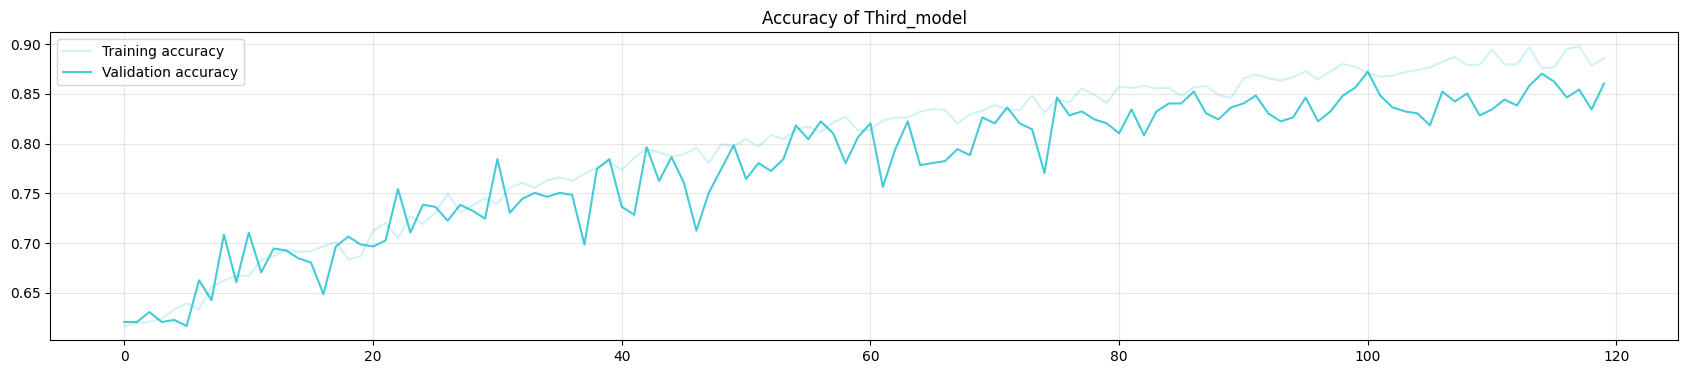

In [53]:
plot_accuracy(model_history= history, name_of_model= "Third_model")

In [54]:
val_accuracy['Third']=np.max(history['val_accuracy'])

In [55]:
third_model.save("last_models/Third_model.keras")

In [56]:
def trun_to_binary(value):
  if value > 0.5:
    value = 1
  else:
    value = 0
  return value

def prediction(type_model):
  test_accuracy = {}

  if type_model =="last_models":
    for i in (list(val_accuracy.keys())):
      test_model = tf.keras.models.load_model(f"/content/last_models/{i}_model.keras")
      y_pred = test_model.predict(x_test)
      y_pred = np.array(list(map(trun_to_binary, y_pred)))
      test_accuracy[f'{i}'] =  accuracy_score(y_test,y_pred)
    return test_accuracy

  elif type_model=="best_models":
    for i in (list(val_accuracy.keys())):
      test_model = tf.keras.models.load_model(f"/content/best_models/{i}_model")
      y_pred = test_model.predict(x_test)
      y_pred = np.array(list(map(trun_to_binary, y_pred)))
      test_accuracy[f'{i}'] =  accuracy_score(y_test,y_pred)
    return test_accuracy

In [57]:
print("Val_accuracy:")
print(val_accuracy)
print("*"*50)
print("test_accuracy_with_last_models:")
print(prediction(type_model="last_models"))
print("test_accuracy_with_best_models:")
print(prediction(type_model="best_models"))

Val_accuracy:
{'First': 0.7824351191520691, 'Second': 0.802395224571228, 'Third': 0.8722555041313171}
**************************************************
test_accuracy_with_last_models:
16/16 [==============================] - 0s 5ms/step
{'First': 0.7145708582834331, 'Second': 0.7405189620758483, 'Third': 0.8522954091816367}
test_accuracy_with_best_models:
16/16 [==============================] - 0s 5ms/step
{'First': 0.782435129740519, 'Second': 0.7704590818363274, 'Third': 0.8423153692614771}
